<a href="https://colab.research.google.com/github/vuongvmu/GoogleColabDemoCode/blob/main/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [ ]:
# @title Creat model { display-mode: "form" }
latent_dim = 2  # @param {type:"number"}
stack_filters = [32,64] # @param {type:"raw"}
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim),seed=5)
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon
encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(stack_filters[0], 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(stack_filters[1], 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * stack_filters[1], activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, stack_filters[1]))(x)
x = layers.Conv2DTranspose(stack_filters[1], 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(stack_filters[0], 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.mse(data, reconstruction),axis=(1,2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())

In [42]:
# @title Utils . { display-mode: "form" }

def display(array1, array2):
    """
    Displays ten random images from each one of the supplied arrays.
    """
    n = 10
    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]
    plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(image1.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(image2.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()
def plot_latent_space(vae, n=30, figsize=15):
    # display an n*n 2D manifold of digits
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()
def plot_label_clusters(vae, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = vae.encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


In [52]:
# @title Pre data . { display-mode: "form" }
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
#mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(x_train, -1).astype("float32") / 255

In [ ]:

# @title ① Step-> Click to `train`. { display-mode: "form" }
epochs = 1000 # @param {type:"number"}
batch_size=4096# @param {type:"number"}
vae.fit(mnist_digits, epochs=epochs, batch_size=batch_size)

Epoch 1/1000
15/15 [==============================] - 6s 174ms/step - loss: 169.2487 - reconstruction_loss: 148.8637 - kl_loss: 3.4960
Epoch 2/1000
15/15 [==============================] - 3s 172ms/step - loss: 88.3781 - reconstruction_loss: 78.8704 - kl_loss: 1.8155
Epoch 3/1000
15/15 [==============================] - 3s 169ms/step - loss: 65.5993 - reconstruction_loss: 63.1386 - kl_loss: 0.0172
Epoch 4/1000
15/15 [==============================] - 3s 169ms/step - loss: 57.5948 - reconstruction_loss: 56.9454 - kl_loss: 0.0101
Epoch 5/1000
15/15 [==============================] - 3s 171ms/step - loss: 55.3820 - reconstruction_loss: 55.1479 - kl_loss: 0.0154
Epoch 6/1000
15/15 [==============================] - 3s 172ms/step - loss: 54.5899 - reconstruction_loss: 54.4117 - kl_loss: 0.0136
Epoch 7/1000
15/15 [==============================] - 3s 175ms/step - loss: 54.0994 - reconstruction_loss: 54.0479 - kl_loss: 0.0115
Epoch 8/1000
15/15 [==============================] - 3s 172ms/step

313/313 [==============================] - 1s 2ms/step


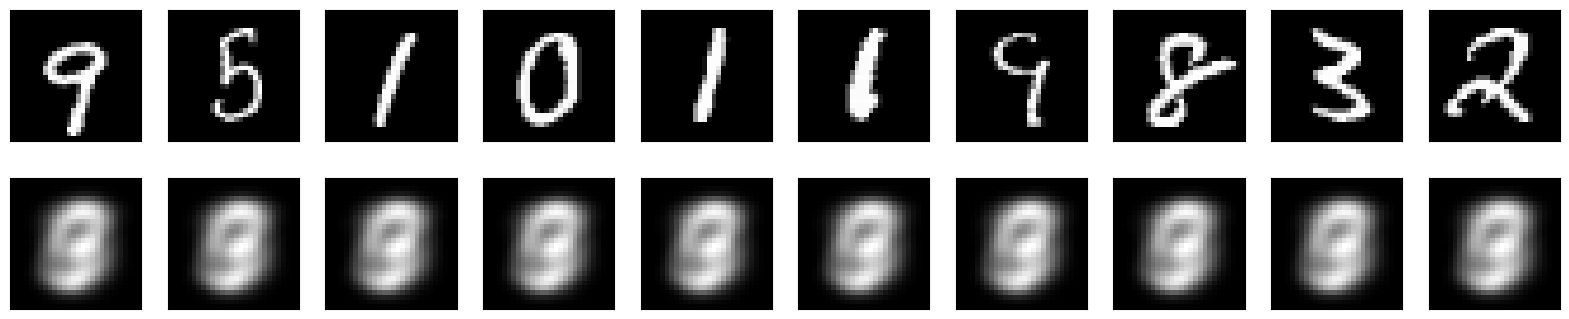

In [80]:
z_mean, _, z = vae.encoder.predict(x_test)
x_decoded = vae.decoder.predict(z)
display(x_test,x_decoded)

In [ ]:
# plot_latent_space(vae)

# (x_train, y_train), _ = keras.datasets.mnist.load_data()
# x_train = np.expand_dims(x_train, -1).astype("float32") / 255

# plot_label_clusters(vae, x_train, y_train)